In the [last post](http://frickp.github.io/python-scrape-nba-shots.html), I pulled some NBA shot data for Andrew Wiggins and put that into a dataframe. Here, we will apply some [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning) techniques from `sklearn` to build predictive models and then use visualizations to better understand the data.

Some topics we'll explore are prediction error, regularization, and the tradeoff between prediction accuracy and model interpretability.

## Getting started
#### Load the dependencies

In [173]:
%matplotlib inline
# For data analysis
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import cm

# For learning algorithms
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn import cross_validation
from sklearn.preprocessing import scale, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

#### Load the data

In [174]:
df = pd.read_csv('../../dataSandbox/forPelican/nbaWiggins.csv')
allShots = df[np.invert(np.isnan(df.SHOT_CLOCK))]
cMin,cSec = allShots.loc[:,'GAME_CLOCK'].str.split(':').str.get(0),allShots.loc[:,'GAME_CLOCK'].str.split(':').str.get(1)
allShots.loc[:,'secGameClock'] = cMin.astype('int') * 60 + cSec.astype('int')

#### Dummify variables

In [175]:
pd.get_dummies(allShots[['W','LOCATION','FGM']])
allShots.loc[:,'gameWon'] = pd.get_dummies(allShots['W'])['W']
allShots.loc[:,'homeGame'] = pd.get_dummies(allShots['LOCATION'])['H']
allShots.loc[:,'is3Pointer'] = pd.get_dummies(allShots['PTS_TYPE'])[3]
q = pd.get_dummies(allShots['PERIOD'])[[2,3,4,5]]
q.columns = ['q' + str(i) for i in q.columns]
allShots = pd.concat([allShots,q],axis=1)

#### Clean up

In [176]:
dropThese = ['GAME_ID','MATCHUP','CLOSEST_DEFENDER','CLOSEST_DEFENDER_PLAYER_ID','GAME_CLOCK','SHOT_RESULT','LOCATION','W','PERIOD','PTS_TYPE','PTS']
[ allShots.drop(i, axis=1, inplace=True) for i in dropThese ] 

[None, None, None, None, None, None, None, None, None, None, None]

#### Split the data into a training and test set

In [177]:
trainShots = allShots[1::2] #Odd rows
testShots = allShots[::2]   #Even rows

# Pluribus machina
Now, we will build a series of function to test machine learning algorithms head-to-head. Since these are all implemented in `sklearn`, it is feasible to create a generalized function to run each learning algorithm.

In [178]:
# Generalized function to implement sklearn learning algorithms

def runLearning(myData,myMod,trainIdx,testIdx,respVar,scaleIt=False,printMe=False): 
    predCol = [col for col in myData.columns if col != respVar] # Get predictor variables
    if scaleIt == True:
        myData = pd.DataFrame(scale(myData), index=myData.index, columns=myData.columns)
    trainSet = eval('myData' + trainIdx).astype(float)
    testSet = eval('myData' + testIdx).astype(float)
    myEst = eval(myMod)
    trainResp = trainSet[respVar].astype(float)
    trainResp.ix[trainResp > 0] = 1    # Need to binarize data or it will break
    trainResp.ix[trainResp <= 0] = 0
    # Train the model
    myEst.fit(
        trainSet[predCol],
        trainResp
    )
    # Test the model
    testResp = testSet[respVar].astype(float)
    testResp.ix[testResp > 0] = 1    # Need to binarize data or it will break
    testResp.ix[testResp <= 0] = 0
    matches = np.count_nonzero(myEst.predict(testSet[predCol]) == testResp)
    testLen = testSet.shape[0]
    if(printMe==True):
        print 'Algorithm used:\n' + myMod + '    scaled=' + str(scaleIt)
        print "Correctly classified:\n" + str(round(float(matches) / testLen * 100,2)) + '%\n\n'
    else:
        return round(float(matches) / testLen * 100,2)

#### Let's try it out for a couple algorithms

In [210]:
runLearning(myData=allShots,myMod='RandomForestClassifier(n_estimators=100)',trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=False,printMe=True) 
runLearning(myData=allShots,myMod='BaggingClassifier()',trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=False,printMe=True) 

Algorithm used:
RandomForestClassifier(n_estimators=100)    scaled=False
Correctly classified:
60.44%


Algorithm used:
BaggingClassifier()    scaled=False
Correctly classified:
59.35%




#### Now, calculate the accuracy for each algorithm

In [180]:
dfPred = pd.DataFrame(columns=['algorithm','accuracy','scaled'])

algs = ['RandomForestClassifier(n_estimators=100)','BaggingClassifier()','SGDClassifier(alpha=2)','RidgeClassifier(alpha=2)','SVC()','LogisticRegression()']
myScale = ['False','False','False','False','True','False']

for i in range(len(algs)):
    # Calculate prediction algorithm for scaled/non-scaled data in each algorithm
    temp1 = runLearning(myData=allShots,myMod=algs[i],trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=myScale[i])
    algName = algs[i]
    algName = algName.split('(')[0]
    dfPred = dfPred.append({'algorithm': algName, 'accuracy': temp1, 'scaled': myScale[i]}, ignore_index = True)
    
#dfPred

,algorithm,accuracy,scaled
0,RandomForestClassifier,60.62,False
1,BaggingClassifier,60.98,False
2,SGDClassifier,54.81,False
3,RidgeClassifier,60.62,False
4,SVC,54.63,True
5,LogisticRegression,60.25,False


### A first pass

Out of the box, it looks like the random forest classifier does the best at predicting whether a shot was made/missed. But consider that _random selection_ would give us an expected accuracy of 0.5, so keep in mind these predictions are far from perfect.

### A brute-force feel for noise

We have the accuracy, but how stable are these predictions? Let's re-run the analyses to get confidence intervals on our accuracy metrics

In [181]:
# Run each learning algorithm 200 times and store in data frame

dfPred = pd.DataFrame(columns=['algorithm','accuracy','scaled'])

algs = ['RandomForestClassifier(n_estimators=100)','BaggingClassifier()','SGDClassifier(alpha=2)','RidgeClassifier(alpha=2)','SVC()','LogisticRegression()']
myScale = ['False','False','False','False','True','False']

# Calculate prediction accuracy for each algorithm
for i in range(len(algs)):
    for j in range(200):    # Sample 200 times to get 95%CI
        temp1 = runLearning(myData=allShots,myMod=algs[i],trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=myScale[i])
        algName = algs[i]
        algName = algName.split('(')[0]
        dfPred = dfPred.append({'algorithm': algName, 'accuracy': temp1, 'scaled': myScale[i]}, ignore_index = True)
    
dfPred.head()

,algorithm,accuracy,scaled
0,RandomForestClassifier,63.52,False
1,RandomForestClassifier,62.25,False
2,RandomForestClassifier,64.43,False
3,RandomForestClassifier,62.61,False
4,RandomForestClassifier,63.34,False


#### Now some functions to calculate statistics for each learning algorithm

In [211]:
def get95CI(df,alg):
    temp = df.loc[dfPred.algorithm==alg]
    temp = temp.sort_values(by='accuracy').reset_index(drop=True)
    temp
    mean = np.mean(temp.accuracy)  # mean
    low95 = mean - temp.ix[4,'accuracy']   # low95
    hi95 = temp.ix[194,'accuracy'] - mean # high95
    return mean, low95, hi95

def getAlgStatSummary(df, alg):
    algStats = get95CI(df, alg)
    df = pd.DataFrame(columns=['algorithm', 'mean', 'low95', 'high95'])
    df = df.append({'algorithm': alg, 'mean': algStats[0], 'low95': algStats[1], 'high95': algStats[2]}, ignore_index = True)
    return df

In [212]:
dfStats = pd.DataFrame(columns=['algorithm', 'mean', 'low95', 'high95'])
for i in  list(set(dfPred.algorithm)):
    dfStats = dfStats.append(getAlgStatSummary(dfPred,i),ignore_index=True)
dfStats = dfStats.sort_values('mean')
dfStats

,algorithm,mean,low95,high95
4,SGDClassifier,52.59725,7.047250e+00,7.472750e+00
3,SVC,54.63000,-1.421085e-13,1.421085e-13
2,BaggingClassifier,59.79290,3.352900e+00,2.457100e+00
0,LogisticRegression,60.25000,0.000000e+00,0.000000e+00
5,RidgeClassifier,60.62000,1.918465e-13,-1.918465e-13
1,RandomForestClassifier,62.54060,2.100600e+00,2.069400e+00


#### Now plot the accuracy metrics with 95% confidence intervals

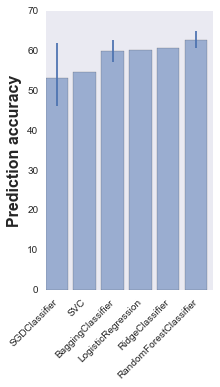

In [186]:
fig = plt.figure(figsize=(3,5), dpi=1600)
ax = plt.subplot(111)

barPlot = plt.bar(range(6),dfStats.loc[:,'mean'],yerr=[list(dfStats.loc[:,'low95']),list(dfStats.loc[:,'high95'])],alpha=0.5)

xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in barPlot]
plt.xticks([i+0.5 for i in range(6)],dfStats.loc[:,'algorithm'],rotation=45,ha='right')
ax.set_ylabel('Prediction accuracy',fontsize=16,fontweight='bold')
plt.show()

## The interpretability/accuracy trade-off

There you have it. We now have a sense of the accuracy and error of the different learning algorithms (prior to tweaking/optimization).

While the Random Forest Classifier is best if you want to predict whether a shot would go in or not, it is a black box. That is, you don't know what each individual predictor is doing in your model.

By contrast, you can choose to use a logistic regression instead. While this algorithm has a reduced prediction accuracy, you can look at the predictor strength to assertain its relative importance.

To make this more concrete, if you want to know if Wiggins' shot will go in, you should use the high accuracy, black box approach (Random Forest). But if you are playing against Wiggins and want to know what you should do to make him miss, you should use the interpretable approach (logistic regression).

### Overfitting? We don't need no stinking overfitting!

All predictors are not created equal. If we use too many predictors, our model will be too complex and we will overfit the data. As a result, we lose prediction accuracy and miss out on some of the underlying relationships.

To account for overfitting, we will utilize [regularization](https://en.wikipedia.org/wiki/Regularization_%28mathematics%29), which serves to penalize the model for complexity. This subsequently reduces the contribution of unimportant variables. 

Luckily, regularization is built into the logistic regression function in `sklearn`, we just need to tune coeffecient value.

In [187]:
#Function to find the best C value for regularization

def findC(cVal):
    tempData = allShots
    trainSet = eval('tempData' + '[1::2]').astype(float)
    testSet = eval('tempData' + '[::2]').astype(float)
    myEst = LogisticRegression(C=cVal)
    predCol = [col for col in allShots.columns if col != 'FGM']
    predVar = trainSet['FGM'].astype(float)
    predVar.ix[predVar>0]=1
    predVar.ix[predVar<=0]=0
    # Train the model
    myEst.fit(
        X=trainSet[predCol],
        y=predVar
    )
    # Test the model
    testVar = testSet['FGM'].astype(float)
    testVar.ix[testVar>0]=1
    testVar.ix[testVar<=0]=0
    matches = np.count_nonzero(myEst.predict(testSet[predCol]) == testVar)
    return matches/float(len(testSet))*100


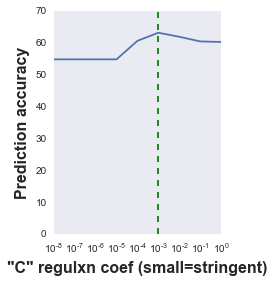

In [189]:
fig = plt.figure(figsize=(3,4), dpi=1600)
ax = plt.subplot(111)

cList=[]
for i in [np.power(10,float(i)) for i in np.arange(0,-9,-1)]:
    cList.append(findC(i))
    
cList
plt.plot([np.power(10,float(i)) for i in np.arange(0,-9,-1)],cList)
ax.set(xscale="log")
ax.set_ylim([0,70])
plt.plot((0.001, 0.001), (0, 70), 'g--')
ax.set_xlabel('"C" regulxn coef (small=stringent)',fontsize=16,fontweight='bold')
ax.set_ylabel('Prediction accuracy',fontsize=16,fontweight='bold')
plt.show()

### Just right...

By optimizing the regularization coefficient (using green dashed line), we were able to increase the prediction accuracy by ~8%.

Now, let's take a look at how each predictor contributes to whether a shot is made or missed.

In [213]:
# Divide the data into training/test set and then perform the logistic regression

trainSet = eval('allShots' + '[1::2]').astype(float)
testSet = eval('allShots' + '[::2]').astype(float)

myEst = LogisticRegression(C=0.001)
predCol = [col for col in allShots.columns if col != 'FGM']
predVar = trainSet['FGM'].astype(float)
predVar.ix[predVar>0]=1
predVar.ix[predVar<=0]=0
# Train the model
myEst.fit(
    X=trainSet[predCol],
    y=predVar
)

# Test the model
testVar = testSet['FGM'].astype(float)
testVar.ix[testVar>0]=1
testVar.ix[testVar<=0]=0

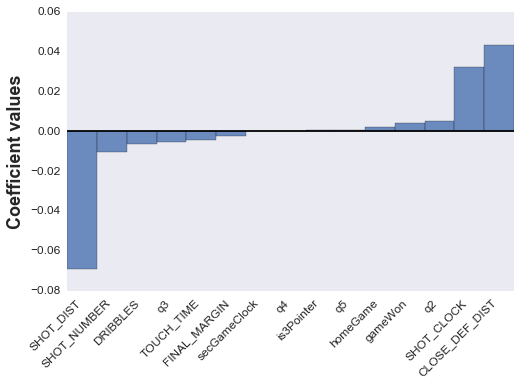

In [216]:
# Plot coefficients for logistic regression (logR)

logR = pd.DataFrame(myEst.coef_)
logR.columns=predCol

fig = plt.figure(figsize=(8,5), dpi=1600)
ax = plt.subplot(111)

logR.ix[0].argsort()
newCol = logR.columns[logR.ix[0].argsort()]
logR = logR[newCol]

sns.set_style("dark")
plt.bar(range(len(predCol)),logR.iloc[0],alpha=0.8,width=1)

plt.xticks([i+0.5 for i in range(len(predCol))],logR.columns,rotation=45,ha='right',fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel('Coefficient values',fontsize=18,fontweight='bold')
plt.plot((0, 15), (0, 0), 'k-')
plt.show()

## Zeroing in

So how to read the graph? Positive values are correlated with made shots and negative values are correlated with missed shots. The magnitude indicates the strength of the correlation.

Reading this graph we see that high shot distance (`SHOT_DIST`) has a large negative value and therefore predicts a miss. By contrast, the closest defender distance (`CLOSE_DEF_DIST`) is a large positive value, indicating that far defenders are associated with made shots. Finally, the final game score margin (`FINAL_MARGIN`) is essentially zero, and we can use this as a negative control.

But these are algorithms and coefficients. I want to see the data! Let's use these coefficients to guide our data exploration.


In [207]:
# Function to compare kernel denisty distributions of made/missed shots
def compareDist(myVar,myTitle,df=allShots,myHist=False):
    made = df.loc[df['FGM'] == True]
    missed = df.loc[df['FGM']  == False]
    sns.distplot(made[myVar],hist=myHist,label="made shots")
    sns.distplot(missed[myVar],hist=myHist,label="missed shots")
    plt.legend();
    plt.title(myTitle,fontsize=16)


### Made-missed denisty analysis

First, let's take a look at the data density for the made missed shots. To ease direct comparison, I'll overlay the [kernel density estimates](https://en.wikipedia.org/wiki/Kernel_density_estimation) for both made and missed shots.

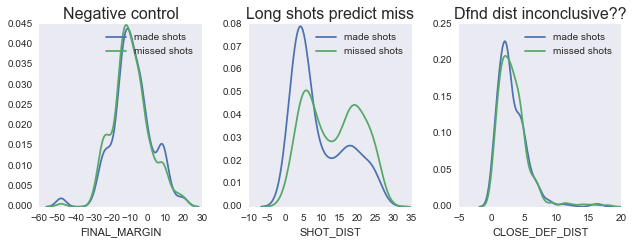

In [223]:
fig = plt.figure(figsize=(9,3.5), dpi=1600)
#plt.subplot(211)
plt.subplot(1,3,1)
compareDist('FINAL_MARGIN','Negative control')
plt.subplot(1,3,2)
compareDist('SHOT_DIST','Long shots predict miss')
plt.subplot(1,3,3)
#compareDist('SHOT_CLOCK','Hi shot clock pred. make')
#plt.subplot(3,1,3)
compareDist('CLOSE_DEF_DIST','Dfnd dist inconclusive??',myHist=False)

#compareDist('SHOT_DIST')
plt.tight_layout()

### Reading the data

In the negative control (left), the curves nearly overlay, which we should expect. 

In the middle graph, we can see, by looking at the differences between the green/blue curves, that for longer shots we would expect a higher amount of misses (the green curve has more density); and vice versa for close shots.

On the far right graph, it looks like the data is basically overlaid, like the negative control. Maybe we need another way of looking at the data, since it doesn't look so nicely bimodal like the middle graph.

#### Let's look instead at shooting percentage as a function of binned defender distance

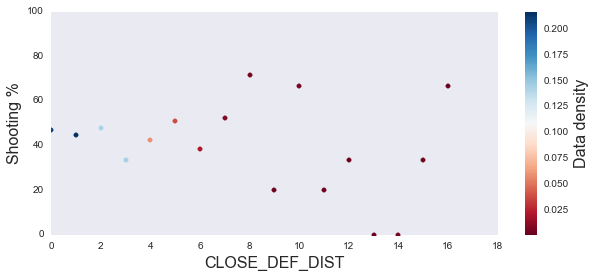

In [255]:
# Function to display kernel density estimates of made/missed shots

def binShotPerPlot(myVar,stepSize):

    fig = plt.figure(figsize=(10,4), dpi=1600)
    maxVal = int(np.ceil(max(allShots[myVar])))
    dfDefDist = pd.DataFrame(columns=['madePerc'])

    myBins = list(np.arange(0,float(maxVal)-stepSize,stepSize))
    for i in myBins:
        madePerc = calcShootPercDist(i,myVar,stepSize=stepSize)
        dfDefDist = dfDefDist.append({'madePerc': madePerc},ignore_index=True)
    
    histHeights, histBins, c = plt.hist(np.array(allShots[myVar]),normed=True,bins=len(myBins))
    dfDefDist['density'] = histHeights

    myCols = cm.RdBu(dfDefDist['density']/max(dfDefDist['density']))

    ax = plt.subplot(111)
    cax = ax.imshow(dfDefDist[['density']], interpolation='nearest', cmap=cm.RdBu)
    fig.clf() #clear the histogram and the `imshow` image

    ax = plt.subplot(111)
    ax.set_ylim(0,100)
    ax.set_xlim(0,maxVal*(1/stepSize)-1)

    spData = dfDefDist['madePerc']

    for i in range(len(spData)-1):
        # if no shots taken, ignore interval
        if dfDefDist.loc[i,'density'] != 0 :
            plt.scatter(i,spData[i],color=([j for  j in myCols[i+1]][0:3]))
    
    ax.set_ylabel('Shooting %',fontsize=16)
    ax.set_xlabel(myVar,fontsize=16)
    cbar = plt.colorbar(cax,label='density')
    cbar.set_label('Data density',size=16)
    plt.show()
    
binShotPerPlot('CLOSE_DEF_DIST',1)

### There it is!

For the data points with higher shot percentage, if is more likely that the closest defender is far away. This is far from a striking correlation, but it helps to predict if a shot went in or not.

## Wrapping up

In this post we looked at using NBA shot data to compare learning algorithms, quantify prediction errors, and examine model accuracy/interpretability. 